In [18]:
import pickle
import numpy as np
import tensorflow as tf
import json
import matplotlib.pyplot as plt

import fasttext
import fasttext.util
from keras.models import Model
from keras.layers import Dropout,Input
# from tensorflow_addons.layers import CRF
from keras.layers import Dense
from keras.layers import Embedding
from keras.models import Sequential
from keras.callbacks import Callback
from keras.preprocessing.text import *
from keras.utils import to_categorical
from gensim.models import KeyedVectors
from keras.layers import GRU, SimpleRNN, LSTM, Bidirectional
from keras.layers import TimeDistributed
from keras.metrics import F1Score, Precision, Recall
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import f1_score,classification_report
from tensorflow.keras.optimizers import AdamW
# from tensorflow_addons.losses import SigmoidFocalCrossEntropy
from sklearn.model_selection import GridSearchCV
from tensorflow.keras.optimizers import AdamW, Adam, RMSprop, SGD
import pandas as pd


In [4]:
PATH = "D:/ghd/NLP-Assignments/Assignment2/"
OUTPATH = "D:/ghd/NLP-Assignments/Assignment2/"
# PATH = "D:/nlp/"
# OUTPATH = ""
# Any results you write to the current directory are saved as output.

In [5]:
Embedding_name="word2vec"
Dataset="ATE"
task=''
if Dataset=="NER":
    task="t2"
elif Dataset=="ATE":
    task="t1"

In [24]:
def checking(a):
    print("Hello World",a)

def new_checking(a):
    print("Hello World",a)

def create_train_test_val(file):
    lst_out_text=[]
    lst_out_labels=[]
    for i in file.values():
        sentence = i['text']
        sentence = sentence.lower()
        labels = i['labels']
        lst_out_text.append(sentence)
        lst_out_labels.append(labels)
    return lst_out_text,lst_out_labels    

def TokenCreator(sentences,val,tokenizer=None):
    
    temp_wordlist = None
    tokenizer2=None
    if(tokenizer == None):
        if val==1:
            tokenizer2 = Tokenizer(oov_token="#UK",filters='')
        else:
            tokenizer2=Tokenizer()
        tokenizer2.fit_on_texts(sentences)
        
        temp_wordlist = tokenizer2.texts_to_sequences(sentences)
        return (temp_wordlist,tokenizer2)
    
    else:
        temp_wordlist = tokenizer.texts_to_sequences(sentences)
        return temp_wordlist
    
def find_vocab(dataset):
    lst=[]
    lst.append("#UK")
    for i in dataset:
        for j in i:
            lst.append(j)
    st = set(lst)
    return st

'''
--------------------------------------GRAPHS--------------------------------------
'''

def draw_loss_graph(model,model_name,f1_scores_train,f1_scores_val):
    train_loss = model.history['loss']
    val_loss = model.history['val_loss']
    x = [i+1 for i in range(len(train_loss))]
    train_y = train_loss
    val_y = val_loss
    
    fig, axes = plt.subplots(1,2,figsize = (16,5))
    # plt.subplots(axes = (2,1))
    axes[0].plot(x,train_y, color = 'blue')  
    
    axes[0].plot(x,val_y, color = 'red') 
    axes[0].set_title('Loss over Epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')

    axes[1].plot(x,f1_scores_train, color = 'blue')
    axes[1].plot(x,f1_scores_val, color = 'red')
    axes[1].set_title('F1 Score vs Epoch')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('F1 Score')

    axes[0].legend(['Train','Val'])
    axes[1].legend(['Train','Val'])
    
    plt.suptitle(model_name)

    
    plt.savefig(f'{OUTPATH}Graphs/{model_name}.png')
    plt.show()
    

In [20]:
'''
--------------------------------------MODELS--------------------------------------
'''

def save_model(model,model_name, embedding, dataset):
    with open(f'{PATH}Saved_Models/{dataset}/{model_name}_{embedding}.pkl', 'wb') as file:
        pickle.dump(model, file)

def load_model(model_name, embedding, dataset):
    with open(f'{OUTPATH}Final_Models/{dataset}/{task}_{model_name}_{embedding}.pkl', 'rb') as file:
        loaded_model = pickle.load(file)
    return loaded_model


In [25]:
'''
--------------------------------------CALLBACKS--------------------------------------
'''

class F1ScoreCallback(Callback):

    def __init__(self, val_data, data):
        super(F1ScoreCallback, self).__init__()
        self.val_data = val_data
        self.data=data
        self.val_f1_scores = [] 
        self.train_f1_scores = []

    

    def on_epoch_end(self, epoch, logs=None):
        x_val, y_val = self.val_data
        x_data, y_data = self.data
        y_pred_val = self.model.predict(x_val)
        y_pred_train = self.model.predict(x_data)

        def scikitf1(pred,real):

            true_labels_flat = [label for sublist in real for label in sublist]
            predicted_labels_flat = [label for sublist in pred for label in sublist]
            # Compute F1 score
            f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
            return f1
        def get_pred(Y_padded_output):
                # print(Y_padded_output.shape)
                final_output=[]
                for i in range(Y_padded_output.shape[0]):
                    output=[]
                    for j in range(Y_padded_output.shape[1]):
                        max_value=-1
                        maxIndex=-1
                        for k in range(Y_padded_output.shape[2]):
                            if Y_padded_output[i][j][k]>max_value:
                                maxIndex=k
                                max_value=max(max_value,Y_padded_output[i][j][k])
                        output.append(maxIndex)
                    final_output.append(output)
                return final_output

        def get_real(Y_padded_test):
            # print(Y_padded_test.shape)
            final_Y=[]
            for i in range(Y_padded_test.shape[0]):
                output=[]
                for j in range(Y_padded_test.shape[1]):
                    max_value=-1
                    maxIndex=-1
                    for k in range(Y_padded_test.shape[2]):
                        if Y_padded_test[i][j][k]>max_value:
                            maxIndex=k
                            max_value=max(max_value,Y_padded_test[i][j][k])
                    output.append(maxIndex)
                final_Y.append(output)
            return final_Y
        
        # print("here")
        pred_train=get_pred(y_pred_train)
        # print(pred_train)
        real_train=get_real(y_data)
        # print(real_train)

        pred_val=get_pred(y_pred_val)
        real_val=get_real(y_val)

        f1_train = scikitf1(pred_train,real_train)
        f1_val = scikitf1(pred_val,real_val)

        self.val_f1_scores.append(f1_val)
        self.train_f1_scores.append(f1_train)
        print(f'Val F1 Score: {f1_val} - Train F1 Score: {f1_train}')



#---------Prediction Functions----------------------------------------------
def get_pred(Y_padded_output):
    final_output=[]
    for i in range(Y_padded_output.shape[0]):
        output=[]
        for j in range(Y_padded_output.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_output.shape[2]):
                if Y_padded_output[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_output[i][j][k])
            output.append(maxIndex)
        final_output.append(output)
    return final_output

def get_real(Y_padded_test):
    final_Y=[]
    for i in range(Y_padded_test.shape[0]):
        output=[]
        for j in range(Y_padded_test.shape[1]):
            max_value=-1
            maxIndex=-1
            for k in range(Y_padded_test.shape[2]):
                if Y_padded_test[i][j][k]>max_value:
                    maxIndex=k
                    max_value=max(max_value,Y_padded_test[i][j][k])
            output.append(maxIndex)
        final_Y.append(output)
    return final_Y

def my_f1(y_true, y_pred):
    
    # predictions = get_pred(y_pred)
    # real = get_real(y_true)

    predictions = y_pred
    real = y_true

    size=len(predictions)

    unique_labels= set()

    for labels in real:
        unique_labels.update(labels)

    for labels in predictions:
        unique_labels.update(labels)

    labels_f1=[]

    for labels in unique_labels:
        tp=0
        fp=0
        fn=0

        for i in range(size):
                    
            tp+=sum((p==labels and r==labels) for p,r in zip(predictions[i],real[i]))
            fp+=sum((p==labels and r!=labels) for p,r in zip(predictions[i],real[i]))
            fn+=sum((p!=labels and r==labels) for p,r in zip(predictions[i],real[i]))

        
        precision = tp/(tp+fp) if tp+fp>0 else 0
        recall = tp/(tp+fn) if tp+fn>0 else 0

        f1=2*((precision*recall)/(precision+recall)) if precision+recall>0 else 0

        labels_f1.append(f1)
        print(f1,unique_labels)
    macro_f1 = sum(labels_f1)/len(unique_labels)
    return macro_f1

def scikitf1(pred,real):

    true_labels_flat = [label for sublist in real for label in sublist]
    predicted_labels_flat = [label for sublist in pred for label in sublist]
    # Compute F1 score
    f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')
    return f1

In [ ]:
def report_alllabels(pred,real):
    tag_mapping={v:k for k,v in toke2.word_index.items()}
    tag_mapping[0]="PAD"
    labels=list(tag_mapping.values())
    def convert_sentences_to_values(sentences, word_values):
        result = []
        for sentence in sentences:
            values = []
            for word in sentence:
                values.append(word_values[word])
            result.append(values)
        return result

    y_pred_labels = convert_sentences_to_values(pred,tag_mapping)
    y_true_labels=convert_sentences_to_values(real,tag_mapping)

    print(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels))
    
    df=pd.DataFrame(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)).T
    # all_label_report=classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)
    x = df.index
    x = x[0:-3]
    y = [df.loc[i,'f1-score'] for i in x]
    plt.figure(figsize=(10,8))
    plt.bar(x,y)
    plt.xticks(rotation=90)
    plt.xlabel('Class Labels')
    plt.ylabel('F1-Score')
    plt.title('Classwise F1-Score')

def report_13labels(pred,real):
    tag_mapping={v:k for k,v in toke2.word_index.items()}
    tag_mapping[0]="PAD"
    labels=list(tag_mapping.values())
    def convert_sentences_to_values(sentences, word_values):
        result = []
        for sentence in sentences:
            values = []
            for word in sentence:
                values.append(word_values[word])
            result.append(values)
        return result

    y_pred_labels = convert_sentences_to_values(pred,tag_mapping)
    y_true_labels=convert_sentences_to_values(real,tag_mapping)

    for i in range(len(y_pred_labels)):
        for j in range(len(y_pred_labels[i])):
            # print(y_true_labels[i][j],y_pred_labels[i][j])
            y_true_labels[i][j]=y_true_labels[i][j].replace('i_','b_')
            y_pred_labels[i][j]=y_pred_labels[i][j].replace('i_','b_')

            y_true_labels[i][j]=y_true_labels[i][j].replace('b_','')
            y_pred_labels[i][j]=y_pred_labels[i][j].replace('b_','')
            
    labels2=[]
    for i in labels:
        if 'i_' not in i:
            labels2.append(i)

    for j in range(len(labels2)):
        labels2[j]=labels2[j].replace('b_','')

    report = classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels2)
    print(report)
    df2=pd.DataFrame(classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels2,output_dict=True)).T
# all_label_report=classification_report(np.array(y_true_labels).flatten(), np.array(y_pred_labels).flatten(), target_names=labels,output_dict=True)
    x = df2.index
    x = x[1:-4]
    y = [df2.loc[i,'f1-score'] for i in x]
    plt.figure(figsize=(10,8))
    plt.bar(x,y)
    plt.xticks(rotation=90)
    plt.xlabel('Class Labels')
    plt.ylabel('F1-Score')
    plt.title('Classwise F1-Score')

In [8]:
seed_value = 18
np.random.seed(seed_value)


In [9]:
if Embedding_name=="word2vec":
    emb = KeyedVectors.load_word2vec_format(f'{PATH}WordEmbeddings/Word2Vec.bin',binary=True)
if Embedding_name=="glove":
    with open(f'{PATH}WordEmbeddings/glove.840B.300d.pkl', 'rb') as fp:
        emb = pickle.load(fp)
if Embedding_name=="fasttext":
    emb = fasttext.load_model(f'{PATH}WordEmbeddings/cc.en.300.bin')

# Preproc

In [10]:
train = None
test = None
val = None
with open(f"{PATH}Data/processed/{Dataset}_train.json") as f1:
    train = json.load(f1)

with open(f"{PATH}Data/processed/{Dataset}_test.json") as f2:
    test = json.load(f2)

with open(f"{PATH}Data/processed/{Dataset}_val.json") as f3:
    val = json.load(f3)



In [11]:
X_train,Y_train = create_train_test_val(train)
X_test,Y_test = create_train_test_val(test)
X_val,Y_val = create_train_test_val(val)

In [12]:
X_train_tokenized, toke = TokenCreator(X_train,1)
X_test_tokenized = TokenCreator(X_test,0,tokenizer = toke)
X_val_tokenized = TokenCreator(X_val,0,tokenizer = toke)

Y_train_tokenized,toke2 = TokenCreator(Y_train,0)
Y_test_tokenized = TokenCreator(Y_test,0,tokenizer = toke2)
Y_val_tokenized = TokenCreator(Y_val,0,tokenizer = toke2)

st1 = find_vocab(X_train_tokenized)
vocab_size  = len(st1) + 1 

max_len=0

for i in X_train_tokenized:
    max_len = max(max_len,len(i))

print(max_len)

X_padded_train = pad_sequences(X_train_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_train = pad_sequences(Y_train_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_test = pad_sequences(X_test_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_test = pad_sequences(Y_test_tokenized, maxlen=max_len, padding="pre", truncating="post")

X_padded_val = pad_sequences(X_val_tokenized, maxlen=max_len, padding="pre", truncating="post")
Y_padded_val = pad_sequences(Y_val_tokenized, maxlen=max_len, padding="pre", truncating="post")  

Y_padded_train = to_categorical(Y_padded_train)
Y_padded_test = to_categorical(Y_padded_test)
Y_padded_val = to_categorical(Y_padded_val)

weights = np.zeros((vocab_size, 300))
mapping = toke.word_index 


78


In [13]:
for word, index in mapping.items():
    if word in emb:
        weights[index:] = emb[word]

In [14]:
X_train= X_padded_train
Y_train = Y_padded_train
X_test = X_padded_test
Y_test = Y_padded_test
X_val = X_padded_val
Y_val = Y_padded_val
weights = weights
word_token = toke
tag_token = toke2
Y_shape= Y_padded_train.shape[2]

# TRAINING

## RNN

In [36]:
model_name="RNN"

Loading the rnn Model

In [37]:
def rnn(vocab_size,max_len,weights,Y_shape):
    rnn_model = Sequential()
    rnn_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
    rnn_model.add(SimpleRNN(32, return_sequences=True))
    rnn_model.add(TimeDistributed(Dense(Y_shape, activation='softmax')))
    rnn_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])
    return rnn_model

In [38]:
rnn_loaded_model = rnn(vocab_size,max_len,weights,Y_shape)
params1=load_model(model_name,Embedding_name,Dataset)
rnn_loaded_model.set_weights(params1)

In [39]:
accuracy = rnn_loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 1s 13ms/step - loss: 0.1160 - acc: 0.9719 - precision_4: 0.9759 - recall_4: 0.9437
0.9718574285507202


In [40]:
Y_pred = rnn_loaded_model.predict(X_test)
rnn_real = get_real(Y_test)
rnn_pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in rnn_real for label in sublist]
predicted_labels_flat = [label for sublist in rnn_pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 1s 5ms/step
Test F1 Score: 0.5741517610582809


In [ ]:
pred=rnn_pred
real=rnn_real
report_alllabels(pred,real)
report_13labels(pred,real)

## LSTM

In [41]:
model_name="LSTM"

In [42]:
def lstm(vocab_size,max_len,weights,Y_shape):
    lstm_model = Sequential()
    lstm_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
    lstm_model.add(LSTM(128, return_sequences=True))
    lstm_model.add(TimeDistributed(Dense(Y_train.shape[2], activation='softmax')))# Lstm
    lstm_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])    
    return lstm_model

In [43]:
params2 = load_model(model_name,Embedding_name,Dataset)
lstm_loaded_model=lstm(vocab_size,max_len,weights,Y_shape)
lstm_loaded_model.set_weights(params2)

In [44]:
accuracy = lstm_loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 1s 24ms/step - loss: 0.1034 - acc: 0.9753 - precision_5: 0.9782 - recall_5: 0.9468
0.9752970337867737


In [45]:
Y_pred = lstm_loaded_model.predict(X_test)
lstm_real = get_real(Y_test)
lstm_pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in lstm_real for label in sublist]
predicted_labels_flat = [label for sublist in lstm_pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 1s 15ms/step
Test F1 Score: 0.5819878469718709


              precision    recall  f1-score   support

           o       1.00      1.00      1.00     20413
           b       0.67      0.24      0.36       463
           i       1.00      0.02      0.03       243
         PAD       0.89      0.99      0.94      4465

    accuracy                           0.98     25584
   macro avg       0.89      0.56      0.58     25584
weighted avg       0.97      0.98      0.97     25584

              precision    recall  f1-score   support

           o       1.00      1.00      1.00     20413
           b       0.67      0.24      0.36       463
           i       1.00      0.02      0.03       243
         PAD       0.89      0.99      0.94      4465

    accuracy                           0.98     25584
   macro avg       0.89      0.56      0.58     25584
weighted avg       0.97      0.98      0.97     25584



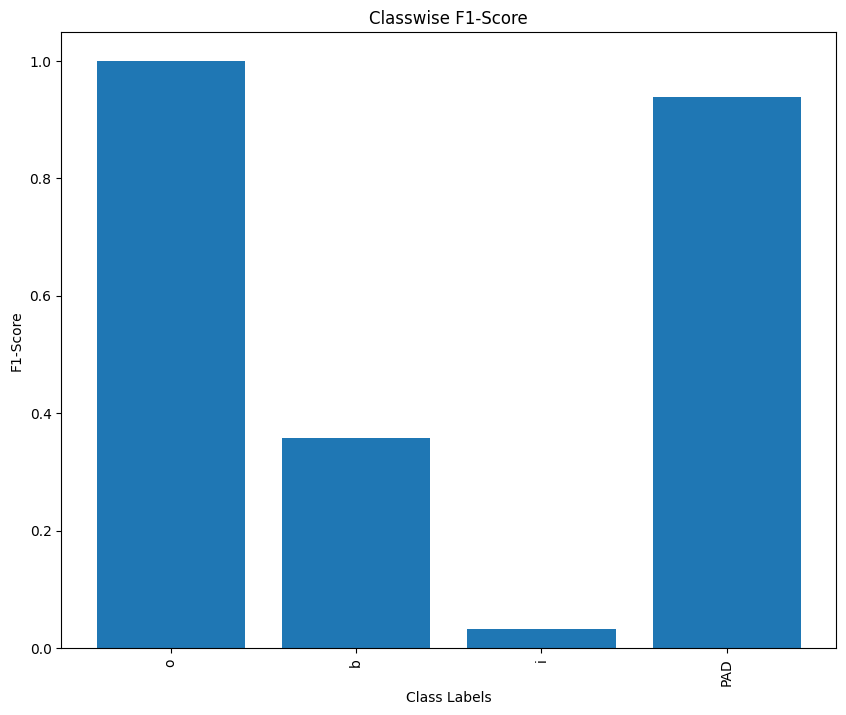

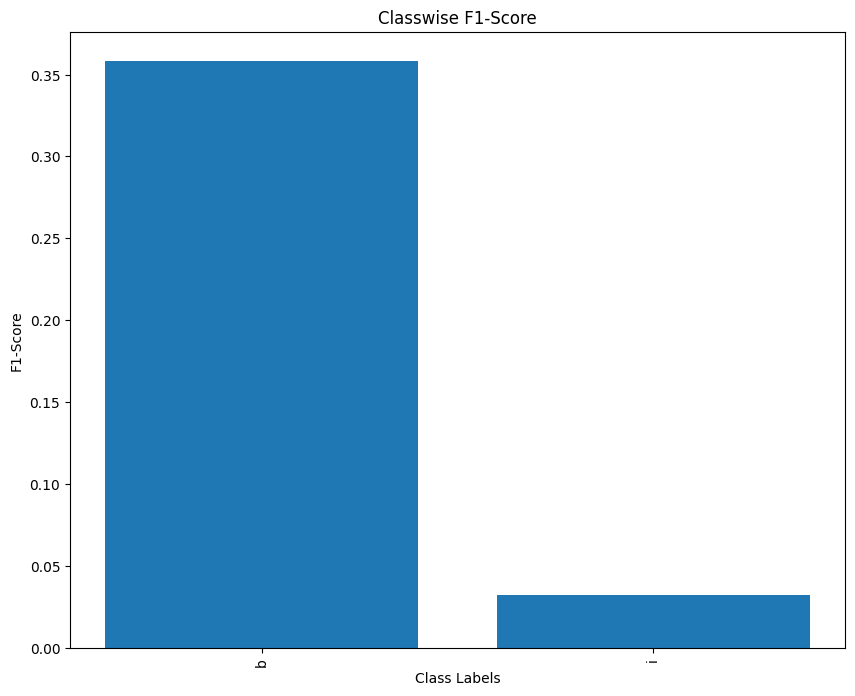

In [54]:
pred=lstm_pred
real=lstm_real
report_alllabels(pred,real)
report_13labels(pred,real)

## GRU

In [46]:
model_name="GRU"

In [47]:
def gru(vocab_size,max_len,weights,Y_train_shape):
    gru_model = Sequential()
    gru_model.add(Embedding(input_dim = vocab_size,output_dim = 300,input_length  = max_len,weights = [weights],trainable = False))
    gru_model.add(GRU(64, return_sequences=True))
    gru_model.add(TimeDistributed(Dense(Y_train_shape, activation='softmax')))
    gru_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['acc',Precision(),Recall()])
    return gru_model

In [48]:
params3 = load_model(model_name,Embedding_name,Dataset)
gru_loaded_model=gru(vocab_size,max_len,weights,Y_shape)
gru_loaded_model.set_weights(params3)

In [49]:
accuracy = gru_loaded_model.evaluate(X_test, Y_test, verbose = 1)
print(accuracy[1])

11/11 [==============================] - 1s 11ms/step - loss: 0.0840 - acc: 0.9779 - precision_6: 0.9828 - recall_6: 0.9612
0.9778767824172974


In [50]:
Y_pred = gru_loaded_model.predict(X_test)
gru_real = get_real(Y_test)
gru_pred = get_pred(Y_pred)

true_labels_flat = [label for sublist in gru_real for label in sublist]
predicted_labels_flat = [label for sublist in gru_pred for label in sublist]

# Compute F1 score
f1 = f1_score(true_labels_flat, predicted_labels_flat, average='macro')

print("Test F1 Score:", f1)

11/11 [==============================] - 1s 8ms/step
Test F1 Score: 0.6555275846443042


              precision    recall  f1-score   support

           o       1.00      1.00      1.00     20413
           b       0.68      0.38      0.49       463
           i       0.81      0.11      0.19       243
         PAD       0.91      0.99      0.95      4465

    accuracy                           0.98     25584
   macro avg       0.85      0.62      0.66     25584
weighted avg       0.98      0.98      0.97     25584

              precision    recall  f1-score   support

           o       1.00      1.00      1.00     20413
           b       0.68      0.38      0.49       463
           i       0.81      0.11      0.19       243
         PAD       0.91      0.99      0.95      4465

    accuracy                           0.98     25584
   macro avg       0.85      0.62      0.66     25584
weighted avg       0.98      0.98      0.97     25584



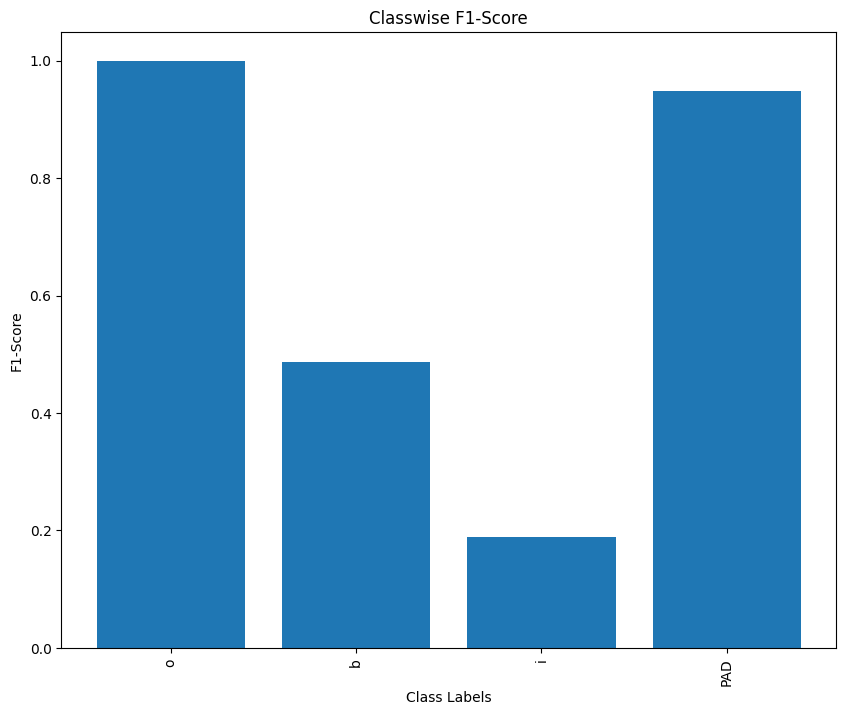

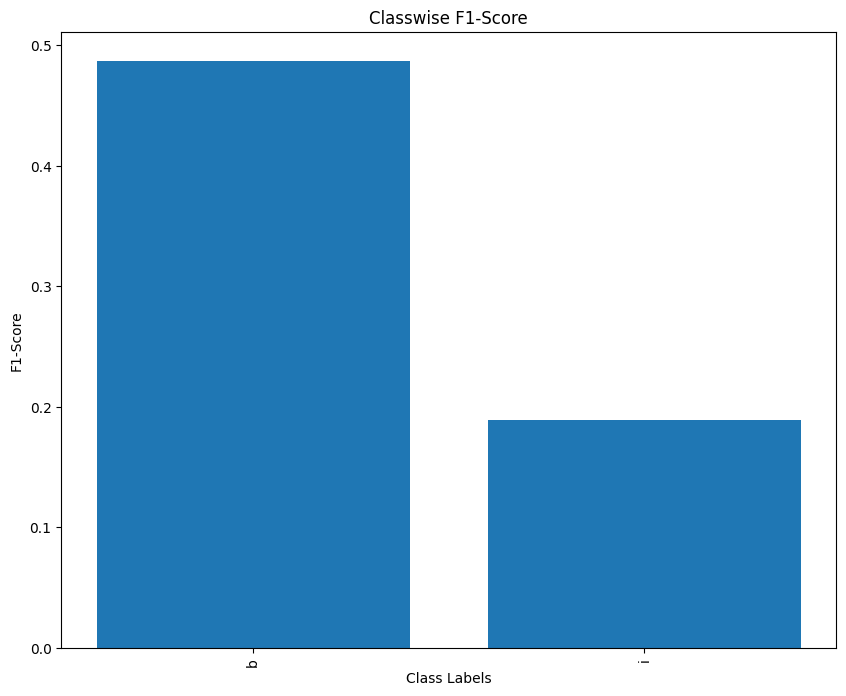

In [55]:
pred=gru_pred
real=gru_real
report_alllabels(pred,real)
report_13labels(pred,real)